In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import clip
import re
import time
import yaml
import os
from matplotlib import pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer
from networks import SCLIPNN, SCLIPNN3
from utils import EmbeddingsDataset, get_models_to_train
import logging
from datetime import datetime

In [2]:
logger = logging.getLogger(__name__)
fhandler = logging.FileHandler(filename='trained_models.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
print("Loading Models...")
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_model.eval()
print("Models Loaded: CLIP, SBERT")

Loading Models...
Models Loaded: CLIP, SBERT


In [5]:
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
params = cfg["training"]

In [13]:
def get_files_paths(directory):
    train_txt = 'train_sentences.txt'    
    valid_txt = 'valid_sentences.txt'
    train_path = os.path.join(directory,train_txt)    
    valid_path = os.path.join(directory,valid_txt)
    return train_path, valid_path
    
def get_sentences_from_file(filename):
    sentences = []
    with open(filename, mode='rt', encoding='utf-8') as file_object:
        for line in file_object:
            sentences.append(line)    
    return sentences

def regexification(sentences):
    regex = [r"[^A-Za-z0-9]+|[a-zA-Z][0-9]", r"(?<!\d)[0]\d*(?!\d)", r"\s+", r"[0-9]+"]
    for r in regex:
        sentences = list(map(lambda sentence: re.sub(r, " ", sentence), sentences))
    return sentences

def get_clip_embeddings_old(sentences, batch_size=32):
    tokenized_text = clip.tokenize(sentences).to(device)
    with torch.no_grad():
        clip_embeddings = clip_model.encode_text(tokenized_text)
    return clip_embeddings

def get_clip_embeddings(sentences, batch_size=16):
    tokenized_text = clip.tokenize(sentences).to(device)
    with torch.no_grad():
        clip_embeddings_list = []
        for i in range(0,tokenized_text.size()[0],batch_size):
            tok_batch = tokenized_text[i:i+batch_size]
            clip_embeddings_batch = clip_model.encode_text(tok_batch).to(device)
            for unity in clip_embeddings_batch:
                clip_embeddings_list.append(unity)
    final_emb = torch.stack(clip_embeddings_list)
    return final_emb

def get_sbert_embeddings(sentences):
    with torch.no_grad():  
        sbert_embeddings = torch.from_numpy(sbert_model.encode(sentences))
    return sbert_embeddings

def show_embeddings_return_size(sentences, clip_embeddings, sbert_embeddings):
    ("-"*10)
    for sentence, clip_embedding, sbert_embedding in zip(sentences[:1], clip_embeddings[:1], sbert_embeddings[:1]):
        print("Sentence:", sentence)
        input_size = sbert_embedding.size()[0]    
        print("Sbert Embedding: ", input_size)
        print("Clip Embedding: ", clip_embedding.size()[0])
        print("-"*10)
    return input_size

In [36]:
def show_plot(models,model_train_losses,model_valid_losses,plot_name):
    rows = 2
    columns = int((len(models)+1)/2)
    fig, axs = plt.subplots(rows,columns,figsize=(18,10))
    positions = []
    for r in range(rows):
        for c in range(columns):
            positions.append((r,c))
    for i, (name, model) in enumerate(models.items()):
        axs[positions[i]].plot(model_train_losses[i][1:], label = 'train '+ name)
        axs[positions[i]].plot(model_valid_losses[i][1:], label = 'valid '+ name, marker = '*')
        axs[positions[i]].set_title('Losses of '+ name)
        axs[positions[i]].grid()
        axs[positions[i]].legend()
    
    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Loss')
    
    #fig.legend()
    #fig.title('Losses per Epoch')
    
    plt.savefig(os.path.join('imgs',plot_name+'.png'))
    plt.show()

In [15]:
def train(model, train_dataset, valid_dataset, b_size=32, epochs=200, print_every=params["print_every"]):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)    
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss = 0.0
        model.train()
        train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=b_size, shuffle=True)
        train_counter = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.to(float), labels.to(float))       
            loss.backward()
            optimizer.step()
            train_loss += loss.item()         
            train_counter += 1
        train_losses.append(train_loss/train_counter)
        
        valid_loss = 0.0
        model.eval()
        valid_counter = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            target = model(inputs)
            loss = criterion(target.to(float), labels.to(float))
            valid_loss += loss.item()
            valid_counter += 1
        valid_losses.append(valid_loss/valid_counter)
        if (epoch % print_every == 0) or (epoch == epochs - 1):
            print("Epoch {}. Train Loss: {}. Valid Loss: {}".format(epoch, train_loss/train_counter, valid_loss/valid_counter))
    return train_losses, valid_losses

In [44]:
def supra_training(models,train_sbert_emb,train_clip_emb,valid_sbert_emb, valid_clip_emb, trainset,n_epochs):
    model_train_losses = []
    model_valid_losses = []
    final_loss = []
    training_time = []
    for name, model in models.items():
        start_time = time.time()
        train_dataset = EmbeddingsDataset(train_sbert_emb, train_clip_emb)
        valid_dataset = EmbeddingsDataset(valid_sbert_emb, valid_clip_emb)
        train_loss, valid_loss = train(model, train_dataset, valid_dataset,epochs=n_epochs)
        date_time = datetime.now()
        str_date_time = date_time.strftime("%d-%m-%Y, %H:%M:%S")
        logger.info(f'Trained model called {trainset}_{name}_{n_epochs}_{train_size}.pt at {str_date_time}')
        torch.save(model.state_dict(), os.path.join('models',trainset + '_' + name +'_'+str(n_epochs)+ '.pt'))
        model_train_losses.append(train_loss)                   
        model_valid_losses.append(valid_loss)
        final_loss.append(round(valid_loss[-1],3))
        end_time = time.gmtime(time.time() - start_time)
        elapsed_time = time.strftime("%H:%M:%S", end_time)
        training_time.append(elapsed_time)
        print('Finished Training from model {}. Elapsed time: {}.'.format(name,elapsed_time))
        #print("-"*50)        
    actual_time = time.strftime("%Y/%m/%d, %H:%M:%S", time.gmtime(time.time()))
    print("End of Training Process on {}".format(actual_time))
    return model_train_losses, model_valid_losses, training_time, final_loss

In [29]:
def get_train_embeddings(directory):
    train_file, valid_file = get_files_paths(directory)
    train_sentences = regexification(get_sentences_from_file(train_file))
    valid_sentences = regexification(get_sentences_from_file(valid_file))
    print("CLIP encoding...")
    train_clip_embeddings = get_clip_embeddings(train_sentences)
    valid_clip_embeddings = get_clip_embeddings(valid_sentences)
    print("SBERT encoding...")
    train_sbert_embeddings = get_sbert_embeddings(train_sentences)
    valid_sbert_embeddings = get_sbert_embeddings(valid_sentences)
    return train_clip_embeddings, valid_clip_embeddings, train_sbert_embeddings, valid_sbert_embeddings

In [45]:
def run_pipeline(directory, n_epochs):### Training Pipeline
    durations = {}
    finals = {}
    model_dict = {}
    train_clip_emb, valid_clip_emb, train_sbert_emb, valid_sbert_emb = get_train_embeddings(directory)
    train_size = train_sbert_emb.size()[0]
    input_size = train_sbert_emb.size()[1]
    print(f'DEBUG: Train Size: {train_size}. Input Size: {input_size}') 
    model_dict[directory] = get_models_to_train(input_size)
    print(f'Training on {directory} dataset')
    print("Train sbert_ emb : {}".format(train_sbert_emb.size()))
    print("Train clip emb: {}".format(train_clip_emb.size()))
    train_losses, valid_losses, train_time,final_loss = supra_training(model_dict[directory],train_sbert_emb,train_clip_emb, valid_sbert_emb, valid_clip_emb,trainset=directory,n_epochs=n_epochs)
    durations[directory] = train_time
    finals[directory] = final_loss
    train_final_losses = [x[-1] for x in train_losses]
    train_results = pd.DataFrame({"TrainLoss":train_final_losses, "ValidLoss":final_loss}, index=model_dict[directory].keys())
    display(train_results)
    show_plot(model_dict[directory],train_losses,valid_losses,directory+'_'+str(n_epochs)+'_'+str(train_size))

CLIP encoding...
SBERT encoding...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

DEBUG: Train Size: 10000. Input Size: 384
Creating Models to train...
4 models created.
Training on europarl dataset
Train sbert_ emb : torch.Size([10000, 384])
Train clip emb: torch.Size([10000, 512])
Epoch 0. Train Loss: 0.24800445659027828. Valid Loss: 0.24108718023579698
Epoch 50. Train Loss: 0.04668683981924994. Valid Loss: 0.04739368853193442
Epoch 100. Train Loss: 0.04635237985455883. Valid Loss: 0.047046170428233045


INFO:__main__:Trained model called europarl_NN_700_150_10000.pt at 31-07-2022, 14:43:05


Epoch 149. Train Loss: 0.04604906429788727. Valid Loss: 0.046740547469184705
Finished Training from model NN_700. Elapsed time: 00:02:32.
Epoch 0. Train Loss: 0.2457104628760391. Valid Loss: 0.23890916757637454
Epoch 50. Train Loss: 0.04661640859801482. Valid Loss: 0.04741000268522365
Epoch 100. Train Loss: 0.04632601359705417. Valid Loss: 0.04709335682829459


INFO:__main__:Trained model called europarl_NN3_700_150_10000.pt at 31-07-2022, 14:46:04


Epoch 149. Train Loss: 0.04608457578732795. Valid Loss: 0.046859562405548484
Finished Training from model NN3_700. Elapsed time: 00:02:58.
Epoch 0. Train Loss: 0.24580200789598133. Valid Loss: 0.23874884907623994
Epoch 50. Train Loss: 0.046590438748426055. Valid Loss: 0.04738939237205095
Epoch 100. Train Loss: 0.046248576696631925. Valid Loss: 0.04704773250912369


INFO:__main__:Trained model called europarl_NN_800_150_10000.pt at 31-07-2022, 14:48:37


Epoch 149. Train Loss: 0.045941529335750624. Valid Loss: 0.0467784711941077
Finished Training from model NN_800. Elapsed time: 00:02:33.
Epoch 0. Train Loss: 0.24549113693096478. Valid Loss: 0.23870815859425087
Epoch 50. Train Loss: 0.04653812647795421. Valid Loss: 0.04727562895342229
Epoch 100. Train Loss: 0.046270693108617554. Valid Loss: 0.04702320281078237


INFO:__main__:Trained model called europarl_NN3_800_150_10000.pt at 31-07-2022, 14:51:36


Epoch 149. Train Loss: 0.046044355542968415. Valid Loss: 0.046844807068702574
Finished Training from model NN3_800. Elapsed time: 00:02:58.
End of Training Process on 2022/07/31, 14:51:36


,TrainLoss,ValidLoss
NN_700,0.046049,0.047
NN3_700,0.046085,0.047
NN_800,0.045942,0.047
NN3_800,0.046044,0.047


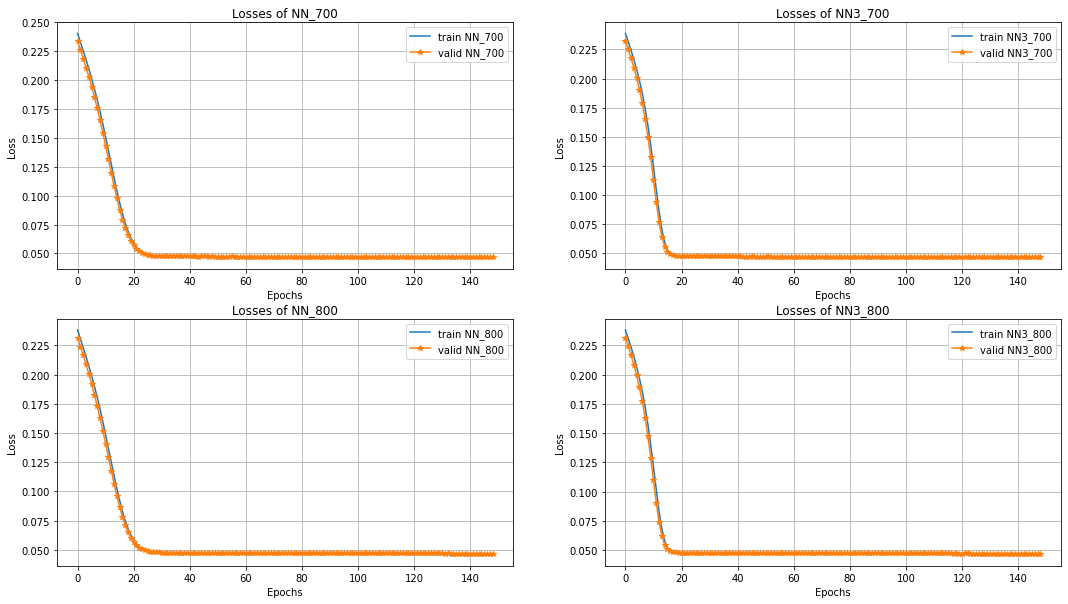

In [46]:
if __name__ == "__main__":
    run_pipeline(params["train_dataset"], params["epochs"])

In [65]:
lista = [1, 2, 3, 4, 5, 6]
lista[2:8]

[3, 4, 5, 6]